In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip data.zip
!unzip model.zip
!unzip util.zip
!unzip SavedModels.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/downSampledImages/0__20161217_180919_0e30__-122.4580609636931_37.76252989470461_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.25570705681058_37.844651758189976_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.36110169563392_37.8090383704882_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.44292051246497_37.86017914204665_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.48871932039954_37.84589395485927_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.5253411209817_37.835177499797524_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180844_0e26__-122.52802558191966_37.84727481184221_downSampled.png  
  inflating: data/downSampledImages/0__20161218_180845_0e26__-122.33170129781017_37.785080771313474_downSampled.png  
  inflating: 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import utils
import cv2
import skimage.measure
import seaborn as sns
from torchvision import transforms as T
from model import esrt
from matplotlib import gridspec
import torch.nn.functional as F

/home/rts3012/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
ANNOTATIONS = 'data/metadata/test.csv'
GT_DIRECTORY = 'data/planesDataset/scenes/scenes/'
LEARNING_RATE = 2e-4
SCALE = 2
STEP_SIZE = 200
GAMMA = 0.5
TEST_BATCH_SIZE = 1
PATCH_SIZE = 40
isY = True
N_COLOURS = 3
RGB_RANGE = 1
DATE = "13_Jun"
MODEL = "Vanilla_ESRT"
OUTPUT_FOLDER = "Test_Outputs/{}/{}/{}x/".format(MODEL, DATE, SCALE)
MODEL_DICT = 'SavedModels/{}/{}/{}x/epoch_100.pth'.format(MODEL, DATE ,SCALE)
upscaled_patch_size = PATCH_SIZE * SCALE
OVERLAP = 10
#Change directory depending on 2x vs 4x
if(SCALE == 2):
    DOWNSAMPLED_DIR = 'data/planesDataset/downSampledScenes05/'
else:
    DOWNSAMPLED_DIR = 'data/planesDataset/downSampledScenes025/'

In [3]:
#Get image, normalise and convert to tensor
imnames = ["scene_1.png","scene_2.png","scene_3.png","scene_4.png"]
inputIms= []
for imname in imnames:
    original_image = cv2.imread(DOWNSAMPLED_DIR + imname.replace('.png', '_downSampled05.png'), cv2.IMREAD_COLOR)[:, :, [2, 1, 0]]
    im_input = original_image / 255.0
    im_input = np.transpose(im_input, (2, 0, 1))
    im_input = im_input[np.newaxis, ...]
    im_input = torch.from_numpy(im_input).float() 
    inputIms.append(im_input)


In [4]:
def create_gaussian_weight_matrix(patch_size, sigma=1.0):
    """Create a Gaussian weight matrix."""
    center = patch_size // 2
    x = torch.arange(0, patch_size).float()
    y = torch.arange(0, patch_size).float()
    x_grid, y_grid = torch.meshgrid(x, y)
    gaussian_kernel = torch.exp(-0.5 * ((x_grid - center) ** 2 + (y_grid - center) ** 2) / sigma ** 2)
    gaussian_kernel /= gaussian_kernel.max()
    return gaussian_kernel

In [25]:
def chop_image_into_patches(image_tensor, patch_size, overlap):
    patches = []
    _, c, h, w = image_tensor.shape
    stride = patch_size - overlap #get stride based on overlap parameter
    for i in range(0, h - overlap, stride): #loop through and get patches based on stride and overlap
        for j in range(0, w - overlap, stride):
            patch = image_tensor[:, :, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches, stride

# Function to apply super-resolution to a patch
def super_resolve_patch(patch, model):
    with torch.no_grad(): #apply model to a patch
        super_resolved_patch = model(patch)
    return super_resolved_patch

def reconstruct_image_from_patches(patches, padded_shape, original_shape, patch_size, stride, upscale_factor):
    _, c, h, w = padded_shape
    _, _, orig_h, orig_w = original_shape
    reconstructed_image = torch.zeros((1, c, h * upscale_factor, w * upscale_factor)) #create tensor of zeros with dimensions of upscaled image
    weight = torch.zeros_like(reconstructed_image)
    patch_size_up = patch_size * upscale_factor
    stride_up = stride * upscale_factor

    index = 0
    for i in range(0, h * upscale_factor - (patch_size_up - stride_up), stride_up):
        for j in range(0, w * upscale_factor - (patch_size_up - stride_up), stride_up):
            reconstructed_image[:, :, i:i+patch_size_up, j:j+patch_size_up] += patches[index]
            weight[:, :, i:i+patch_size_up, j:j+patch_size_up] += 1
            index += 1

    # Average overlapping areas
    reconstructed_image /= weight

    # Remove padding
    reconstructed_image = reconstructed_image[:, :, :orig_h * upscale_factor, :orig_w * upscale_factor]
    return reconstructed_image



In [6]:
# Function to pad image tensor to be divisible by patch size
def pad_image(image_tensor, patch_size, overlap):
    _, _, h, w = image_tensor.shape
    stride = patch_size - overlap
    pad_h = (stride - h % stride) % stride #calculate how much padding is needed
    pad_w = (stride - w % stride) % stride
    padded_image = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect') #pad image
    return padded_image



In [7]:
# Function to compute entropy for image patches
def compute_entropy_patches(image, patch_size):
    h, w = image.shape
    # Calculate number of patches along height and width
    n_patches_h = h // patch_size
    n_patches_w = w // patch_size
    entropy_map = np.zeros((n_patches_h, n_patches_w))
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            entropy_map[i, j] = skimage.measure.shannon_entropy(patch)
    return entropy_map

# Function to resize entropy map to the original image size
def resize_entropy_map(entropy_map, image_shape):
    return cv2.resize(entropy_map, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_NEAREST)


In [8]:
# Function to compute PSNR for image patches
def compute_psnr_patches(gt_image, sr_image, patch_size, im_name):
    h, w = gt_image.shape[:2]
    # Calculate number of patches along height and width
    n_patches_h = h // patch_size
    n_patches_w = w // patch_size
    psnr_map = np.zeros((n_patches_h, n_patches_w))
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            gt_patch = gt_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            sr_patch = sr_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            
            psnr_value = utils.psnr(sr_patch, gt_patch)
    
            if np.isinf(psnr_value) or (psnr_value > 40):
                psnr_map[i, j] = np.nan
            else:
                psnr_map[i, j] = psnr_value
    return psnr_map

# Function to resize PSNR map to the original image size
def resize_psnr_map(psnr_map, image_shape):
    return cv2.resize(psnr_map, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_NEAREST)


In [9]:
if torch.cuda.is_available():
        device = "cuda"
else:
        device = "cpu"
print(f"using {device}")

using cpu


In [10]:
#Load model
model =  esrt.ESRT(upscale = SCALE)
model_dict = utils.load_state_dict(MODEL_DICT, torch.cuda.is_available())
model.load_state_dict(model_dict, strict=False)#True)

scale 0.16666666666666666
288
36


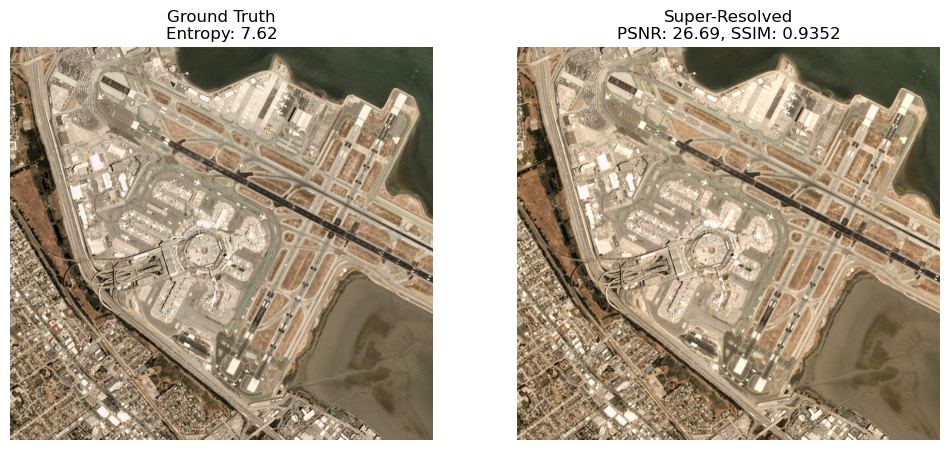

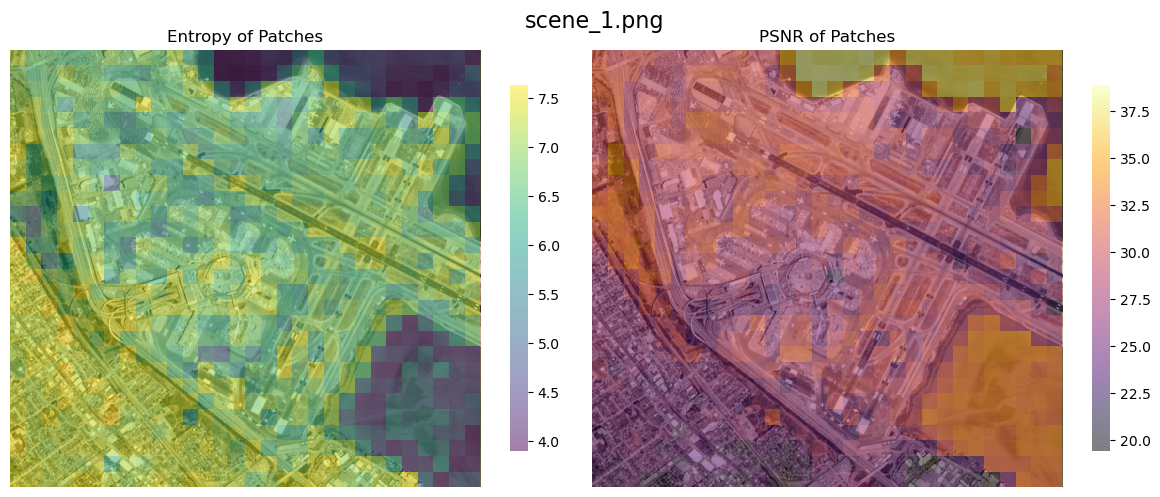

/home/rts3012/anaconda3/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


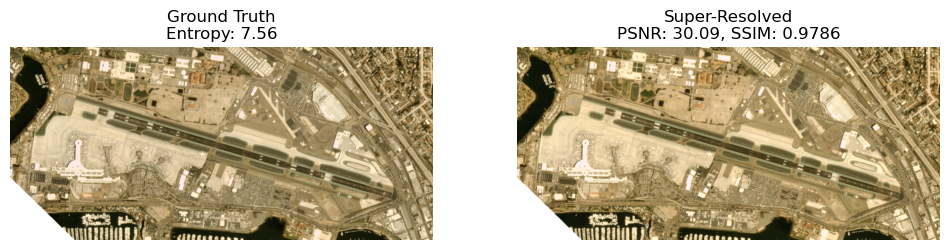

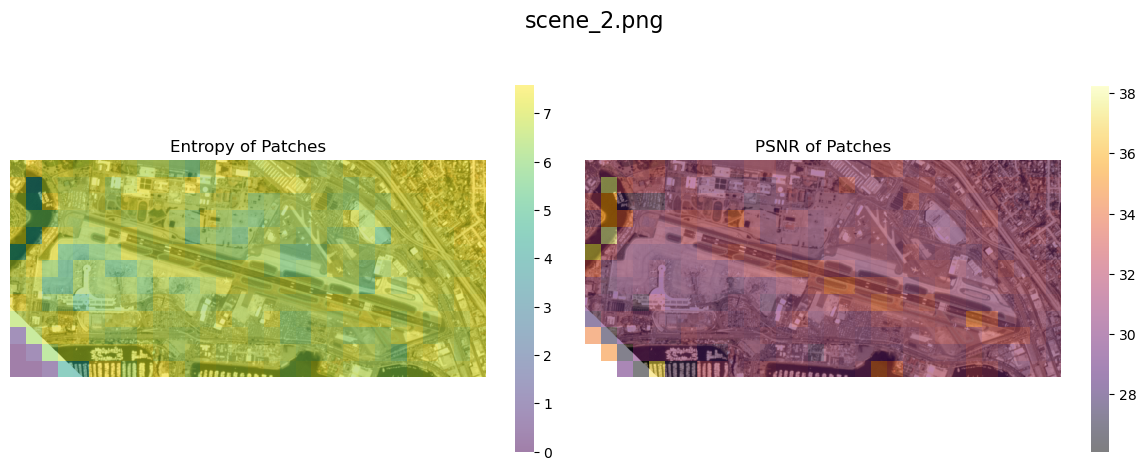

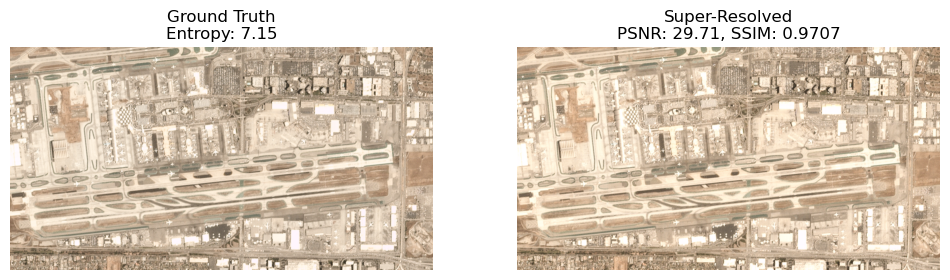

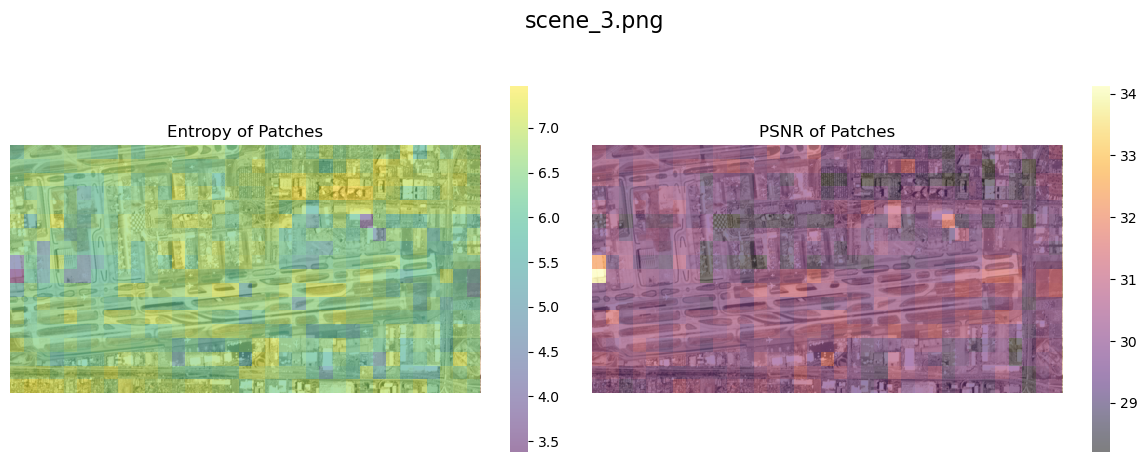

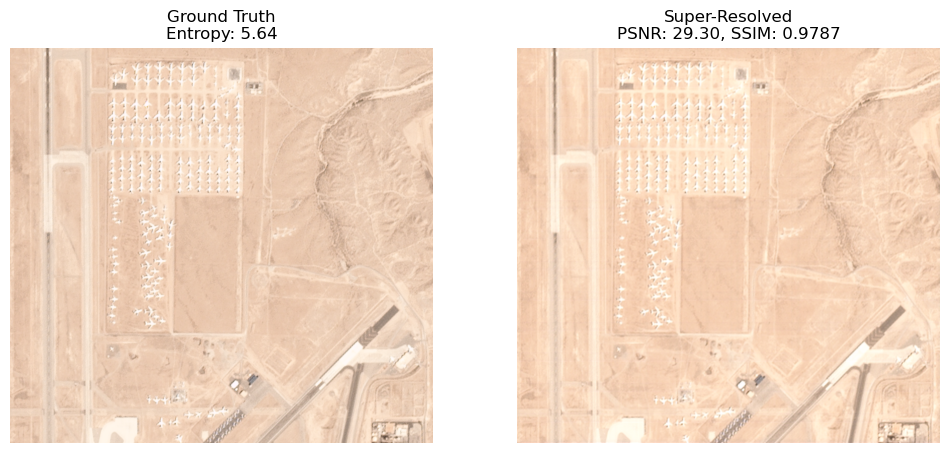

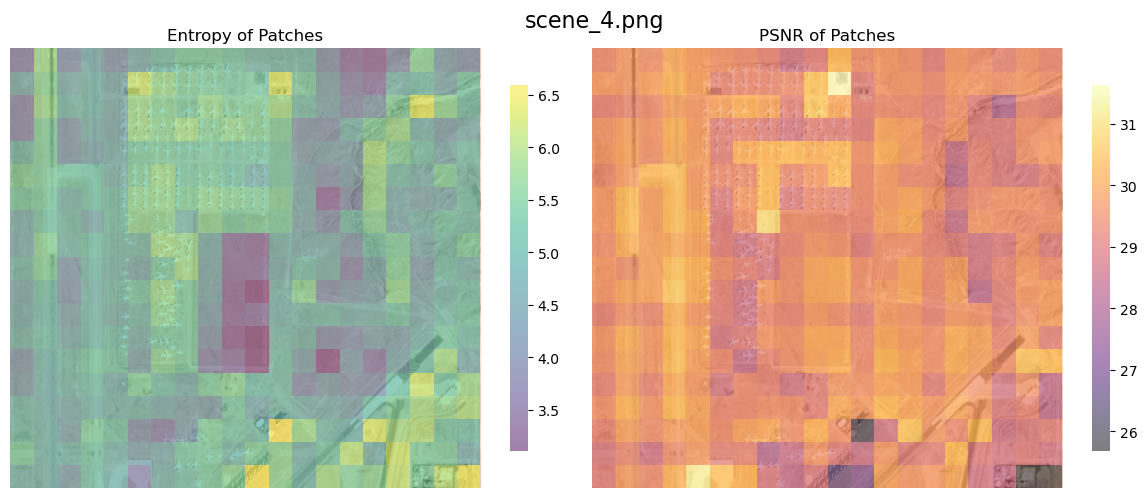

In [26]:
for idx, im_input in enumerate(inputIms): 
    gt_imname = imnames[idx]
    gray_gt_image = cv2.imread(GT_DIRECTORY + gt_imname)
    gray_gt_image = cv2.cvtColor(gray_gt_image, cv2.COLOR_BGR2GRAY) #get gray gt image
    gt_entropy = skimage.measure.shannon_entropy(gray_gt_image) #measure entropy of gt
    im_gt = cv2.imread(GT_DIRECTORY + gt_imname, cv2.IMREAD_COLOR)[:, :, [2, 1, 0]]  # BGR to RGB
    #Pad image
    padded_im_input = pad_image(im_input, PATCH_SIZE, OVERLAP)
    #Chop image into patches
    patches, stride = chop_image_into_patches(padded_im_input, PATCH_SIZE, OVERLAP)
    #Apply super-resolution to each patch
    super_resolved_patches = [super_resolve_patch(patch,model) for patch in patches]
    #Reconstruct the final super-resolved image
    super_resolved_image = reconstruct_image_from_patches(super_resolved_patches, padded_im_input.shape, im_input.shape, PATCH_SIZE, stride, SCALE)
    super_resolved_image = utils.tensor2np(super_resolved_image.detach()[0])
    super_resolved_image= cv2.resize(super_resolved_image, (im_gt.shape[1], im_gt.shape[0]))
    psnr = utils.compute_psnr(super_resolved_image, im_gt) #compute psnr and ssim
    ssim = utils.compute_ssim(super_resolved_image, im_gt)
    
    #cv2.imwrite(gt_imname.replace(".png", "_SR.png"), super_resolved_image[:, :, [2, 1, 0]])
    
    # Compute entropy heatmap
    entropy_heatmap = compute_entropy_patches(gray_gt_image, PATCH_SIZE)
    resized_entropy_map = resize_entropy_map(entropy_heatmap, gray_gt_image.shape)
    psnr_heatmap = compute_psnr_patches(im_gt, super_resolved_image, PATCH_SIZE, gt_imname)
    resized_psnr_map = resize_psnr_map(psnr_heatmap, im_gt.shape)
    
    
    # Plot images and entropy heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Ground Truth Image
    axes[0].imshow(im_gt)
    axes[0].set_title(f'Ground Truth\nEntropy: {gt_entropy:.2f}')
    axes[0].axis('off')
    
    # Super-Resolved Image
    axes[1].imshow(super_resolved_image)
    axes[1].set_title(f'Super-Resolved\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}')
    axes[1].axis('off')
    
    plt.savefig('SR_'+gt_imname+'_Comp.png')
    plt.show()
    
    # Plot images side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    fig.subplots_adjust(wspace=0.05) 
    
    # Add a title to the entire figure with the image name
    fig.suptitle(gt_imname, fontsize=16, y=0.8)
    
    # Overlay Entropy Heatmap on Ground Truth
    axes[0].imshow(im_gt)
    sns.heatmap(resized_entropy_map, ax=axes[0], cmap='viridis', alpha=0.5, cbar=True, cbar_kws={'shrink': 0.5})
    axes[0].set_title('Entropy of Patches')
    axes[0].axis('off')
    
    # Overlay PSNR Heatmap on Ground Truth
    axes[1].imshow(im_gt)
    sns.heatmap(resized_psnr_map, ax=axes[1], cmap='inferno', alpha=0.5, cbar=True, cbar_kws={'shrink': 0.5})
    axes[1].set_title(f'PSNR of Patches')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('SR_PSNRvsEntropy_'+gt_imname+'_Comp.png')
    plt.show()
    